In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

In [2]:
print(os.listdir("X-Ray"))

['Bacterial', 'test', 'train', 'validation', 'Viral']


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

CATEGORIES = ["Bacterial", "Viral"]
DATADIR = 'X-Ray'

image_size = 100

for klasor in CATEGORIES:
    klasor_path = os.path.join(DATADIR, klasor)
    train_path = os.path.join(DATADIR, 'train', klasor)
    validation_path = os.path.join(DATADIR, 'validation',klasor)
    test_path = os.path.join(DATADIR, 'test', klasor)

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(validation_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    resimler = [dosya for dosya in os.listdir(klasor_path) if dosya.endswith('.jpg')]

    train_resimler, test_resimler = train_test_split(resimler, test_size=0.35, random_state=42)

    train_resimler, validation_resimler = train_test_split(train_resimler, test_size=0.1, random_state=42)

    for resim in train_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(train_path, resim)
        shutil.copy(source_path, target_path)

    for resim in validation_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(validation_path, resim)
        shutil.copy(source_path, target_path)

    for resim in test_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(test_path, resim)
        shutil.copy(source_path, target_path)

In [4]:
IMG_SIZE = 100

In [5]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        print(category)
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

Bacterial
Viral


In [6]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  3592


In [7]:

X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2585, 100, 100, 3)
(719, 100, 100, 3)
(288, 100, 100, 3)
(2585,)
(719,)
(288,)


In [11]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from kerastuner.tuners import RandomSearch

# Model fonksiyonunu tanımla
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Hiperparametreler
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

# Tuner'ı tanımla
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Farklı hiperparametre kombinasyonları sayısı
    directory='my_dir',  # Tuner'ın sonuçlarını saklamak için bir dizin
    project_name='my_project'
)

# Modeli eğitim verileri üzerinde eğitme
tuner.search(x_train, train_yCl,
             epochs=5,
             validation_data=(x_val, valid_yCl),
             callbacks=[ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True),
                        EarlyStopping(monitor="val_loss", patience=10)])

# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# En iyi modeli oluştur
best_model = tuner.hypermodel.build(best_hps)

# Modeli eğit
best_model.fit(x_train, train_yCl,
               epochs=5,
               validation_data=(x_val, valid_yCl),
               callbacks=[ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True),
                          EarlyStopping(monitor="val_loss", patience=10)])

# Model değerlendirme
score_valid = best_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = best_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = best_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])


Reloading Tuner from my_dir\my_project\tuner0.json



<ipython-input-12-72d6fdeebebb>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch



Epoch 1/5


81/81 [==============================] - ETA: 0s - loss: 2.0446 - accuracy: 0.5915

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 142s 2s/step - loss: 2.0446 - accuracy: 0.5915 - val_loss: 15.3188 - val_accuracy: 0.6840
Epoch 2/5
81/81 [==============================] - 142s 2s/step - loss: 1.1824 - accuracy: 0.6240 - val_loss: 0.5861 - val_accuracy: 0.7292
Epoch 3/5
81/81 [==============================] - 143s 2s/step - loss: 0.8403 - accuracy: 0.6402 - val_loss: 0.6797 - val_accuracy: 0.6562
Epoch 4/5
81/81 [==============================] - 144s 2s/step - loss: 0.6469 - accuracy: 0.6750 - val_loss: 0.5343 - val_accuracy: 0.7396
Epoch 5/5
9/9 [==============================] - 4s 403ms/step - loss: 0.5559 - accuracy: 0.7118
Validation Accuracy:  0.7118055820465088
23/23 [==============================] - 10s 406ms/step - loss: 0.5531 - accuracy: 0.7538
Test Accuracy:  0.753824770450592
81/81 [==============================] - 32s 389ms/step - loss: 0.5546 - accuracy: 0.7474
Train Accuracy:  0.7473887801170349


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred_prob = best_model.predict(x_test)  # Assuming best_model is the model you want to evaluate
y_pred = np.argmax(y_pred_prob, axis=1)

# Accuracy
accuracy = accuracy_score(np.argmax(test_yCl, axis=1), y_pred)  # Assuming test_yCl is the true labels for the test set
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Precision
precision = precision_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("Precision: {:.2f}".format(precision))

# Recall
recall = recall_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("Recall: {:.2f}".format(recall))

# F1 Score
f1 = f1_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("F1 Score: {:.2f}".format(f1))

# Karmaşıklık Matrisi
conf_mat = confusion_matrix(np.argmax(test_yCl, axis=1), y_pred)
print("Confusion Matrix:\n", conf_mat)

# Classification Report
class_report = classification_report(np.argmax(test_yCl, axis=1), y_pred, target_names=CATEGORIES)
print("Classification Report:\n", class_report)

23/23 [==============================] - 8s 331ms/step
Accuracy: 75.38%
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
Confusion Matrix:
 [[359  81]
 [ 96 183]]
Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.79      0.82      0.80       440
       Viral       0.69      0.66      0.67       279

    accuracy                           0.75       719
   macro avg       0.74      0.74      0.74       719
weighted avg       0.75      0.75      0.75       719



Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.5393 

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 234s 21s/step - loss: 0.9344 - accuracy: 0.5393 - val_loss: 117725.9609 - val_accuracy: 0.3403
Epoch 2/5
11/11 [==============================] - 236s 21s/step - loss: 0.8107 - accuracy: 0.5849 - val_loss: 976.6677 - val_accuracy: 0.6424
Epoch 3/5
11/11 [==============================] - 232s 21s/step - loss: 0.7528 - accuracy: 0.6058 - val_loss: 185089.6406 - val_accuracy: 0.6632
Epoch 4/5
11/11 [==============================] - 234s 21s/step - loss: 0.7327 - accuracy: 0.6221 - val_loss: 6.7834 - val_accuracy: 0.6597
Epoch 5/5
11/11 [==============================] - 233s 21s/step - loss: 0.7265 - accuracy: 0.6248 - val_loss: 3495.9492 - val_accuracy: 0.6979


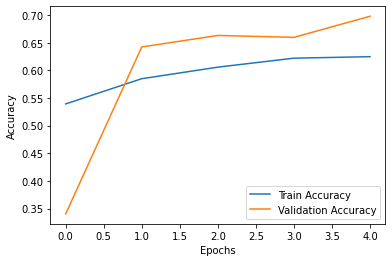

23/23 [==============================] - 17s 717ms/step - loss: 6168.9507 - accuracy: 0.6704
Transfer Learning Test Accuracy: 67.04%


In [15]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# VGG16 modelini kullanarak yeni bir model oluşturun
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential()

# Önceden eğitilmiş VGG16 modelini ekleyin
model.add(base_model)

# Flatten layer ekleyin
model.add(Flatten())

# Tamamen bağlı katman ekleyin
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sınıf sayısı kadar çıkış katmanı ekleyin
model.add(Dense(2, activation='softmax'))

# Modeli derleme
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitim verileri üzerinde eğitme
history = model.fit(x_train, train_yCl,
                    epochs=5,
                    batch_size=256,
                    validation_data=(x_val, valid_yCl),
                    callbacks=[ModelCheckpoint("best_transfer_learning_model.h5", monitor="val_loss", save_best_only=True),
                               EarlyStopping(monitor="val_loss", patience=3)],
                    verbose=1)

# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Transfer learning modelinin test doğruluğunu değerlendirme
score_transfer_learning = model.evaluate(x_test, test_yCl)
print("Transfer Learning Test Accuracy: {:.2f}%".format(score_transfer_learning[1] * 100))


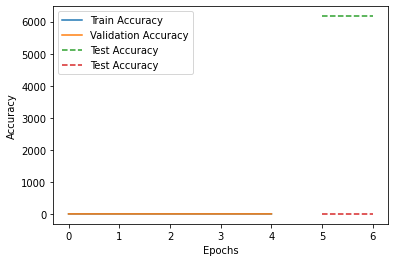

In [16]:
# Test doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot([len(history.history['accuracy']) + i for i in range(len(score_transfer_learning))], [score_transfer_learning] * len(score_transfer_learning), label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Modelin tahminlerini alın
# Modelin tahminlerini alın
y_pred_transfer_learning_prob = model.predict(x_test)
y_pred_transfer_learning = np.argmax(y_pred_transfer_learning_prob, axis=1)


# One-hot encoding'i geri dönüştür
y_true_transfer_learning = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy_transfer_learning = accuracy_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Test Accuracy: {:.2f}%".format(accuracy_transfer_learning * 100))

# Precision
precision_transfer_learning = precision_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Precision: {:.2f}".format(precision_transfer_learning))

# Recall
recall_transfer_learning = recall_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Recall: {:.2f}".format(recall_transfer_learning))

# F1 Score
f1_transfer_learning = f1_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning F1 Score: {:.2f}".format(f1_transfer_learning))

# Karmaşıklık Matrisi
conf_mat_transfer_learning = confusion_matrix(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Confusion Matrix:\n", conf_mat_transfer_learning)

# Classification Report
class_report_transfer_learning = classification_report(y_true_transfer_learning, y_pred_transfer_learning, target_names=CATEGORIES)
print("Transfer Learning Classification Report:\n", class_report_transfer_learning)


23/23 [==============================] - 16s 711ms/step
Transfer Learning Test Accuracy: 67.04%
Transfer Learning Precision: 0.69
Transfer Learning Recall: 0.27
Transfer Learning F1 Score: 0.39
Transfer Learning Confusion Matrix:
 [[406  34]
 [203  76]]
Transfer Learning Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.67      0.92      0.77       440
       Viral       0.69      0.27      0.39       279

    accuracy                           0.67       719
   macro avg       0.68      0.60      0.58       719
weighted avg       0.68      0.67      0.63       719



In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Yapay Sinir Ağı Modeli
model_custom = Sequential()

model_custom.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.25))

model_custom.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.25))

model_custom.add(Flatten())
model_custom.add(Dense(512, activation='relu'))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.5))

model_custom.add(Dense(2, activation='softmax'))


In [19]:
# Modeli derleme
model_custom.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Modeli eğitme
history_custom = model_custom.fit(x_train, train_yCl,
                                  epochs=5,
                                  batch_size=512,
                                  validation_data=(x_val, valid_yCl),
                                  callbacks=[ModelCheckpoint("best_custom_model.h5", monitor="val_loss", save_best_only=True),
                                             EarlyStopping(monitor="val_loss", patience=3)],
                                  verbose=1)

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 3.4986 - accuracy: 0.6302

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 16s 2s/step - loss: 3.4986 - accuracy: 0.6302 - val_loss: 103.4843 - val_accuracy: 0.3403
Epoch 2/5
6/6 [==============================] - 17s 3s/step - loss: 0.8782 - accuracy: 0.7215 - val_loss: 22.3277 - val_accuracy: 0.3924
Epoch 3/5
6/6 [==============================] - 17s 3s/step - loss: 0.6151 - accuracy: 0.7095 - val_loss: 9.1708 - val_accuracy: 0.5035
Epoch 4/5
6/6 [==============================] - 21s 3s/step - loss: 0.5788 - accuracy: 0.7207 - val_loss: 3.6581 - val_accuracy: 0.5868
Epoch 5/5
6/6 [==============================] - 17s 3s/step - loss: 0.5791 - accuracy: 0.7404 - val_loss: 1.9055 - val_accuracy: 0.6667


In [21]:
# Test verisi üzerinde modelin performansını değerlendirme
y_pred_custom_prob = model_custom.predict(x_test)
y_pred_custom = np.argmax(y_pred_custom_prob, axis=1)

# One-hot encoding'i geri dönüştür
y_true_custom = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy_custom = accuracy_score(y_true_custom, y_pred_custom)
print("Custom Model Test Accuracy: {:.2f}%".format(accuracy_custom * 100))

# Precision
precision_custom = precision_score(y_true_custom, y_pred_custom)
print("Custom Model Precision: {:.2f}".format(precision_custom))

# Recall
recall_custom = recall_score(y_true_custom, y_pred_custom)
print("Custom Model Recall: {:.2f}".format(recall_custom))

# F1 Score
f1_custom = f1_score(y_true_custom, y_pred_custom)
print("Custom Model F1 Score: {:.2f}".format(f1_custom))

# Karmaşıklık Matrisi
conf_mat_custom = confusion_matrix(y_true_custom, y_pred_custom)
print("Custom Model Confusion Matrix:\n", conf_mat_custom)

# Classification Report
class_report_custom = classification_report(y_true_custom, y_pred_custom, target_names=CATEGORIES)
print("Custom Model Classification Report:\n", class_report_custom)

23/23 [==============================] - 1s 42ms/step
Custom Model Test Accuracy: 70.38%
Custom Model Precision: 0.61
Custom Model Recall: 0.66
Custom Model F1 Score: 0.63
Custom Model Confusion Matrix:
 [[323 117]
 [ 96 183]]
Custom Model Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.77      0.73      0.75       440
       Viral       0.61      0.66      0.63       279

    accuracy                           0.70       719
   macro avg       0.69      0.70      0.69       719
weighted avg       0.71      0.70      0.71       719

